# <center>**Chess Move Prediction Model**</center>

<img src='chess_board_pic.png'>

## **Table of Contents**

1. [Problem Statement](#problem)
2. [Data Loading and Exploration](#data-loading)
3. [Creating Sentence Structure](#sentence)
4. [Model Selection and Training](#selection)
[<ul>4.1 Bigram Model (Proof of Concept)</ul>](#initial)
[<ul>4.2 N-gram Model</ul>](#fine)
5. [Model Evaluation](#evaluation)
6. [Conclusion](#conclude)

## **1. Problem Statement** <a class="anchor" id="problem"></a>

The goal of this analysis is to create a model to predict the next move of a Chess game given the previous moves in the game using the [Chess Games Data](https://www.kaggle.com/datasets/rishidamarla/chess-games) from Kaggle.  

The model could be used by someone to explore the types of moves strong players play in a given board position to improve their own skill.  Because the number of possible chess games rises exponentially with every move, this model will be limited to the first five moves per player.

## **2. Data Loading and Exploration** <a class="anchor" id="data-loading"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%html
<style>
table {
  float: left;
}
</style>

In [3]:
chess_data = pd.read_csv('chess_games.csv')

In [4]:
chess_data.head(2)

,Game,White,Black,White Elo,Black Elo,White RD,Black RD,WhiteIsComp,BlackIsComp,TimeControl,Date,Time,White Clock,Black Clock,ECO,PlyCount,Result,Result-Winner,Commentaries,Moves
0,"""fjjvh"" vs ""FishTest""",fjjvh,FishTest,818,3204,70.3,51.6,Yes,Yes,60+0,2016.08.28,11:13:00,01:00.0,01:00.0,A13,64,0-1,Black,White checkmated,1. e4 e6 2. d4 d5 3. Nd2 c5 4. exd5 exd5 5. Bb...
1,"""fjjvh"" vs ""birdcostello""",fjjvh,birdcostello,831,3213,69.8,45.9,Yes,Yes,120+0,2016.08.11,15:16:00,02:00.0,02:00.0,C20,24,0-1,Black,White checkmated,1. d4 d5 2. c4 e6 3. Nf3 Nf6 4. g3 c5 5. Bg2 c...


In [5]:
chess_data.duplicated().sum()

0

There are no duplicated rows in the dataset.

In [6]:
chess_data.shape

(48871, 20)

The dataset contains around 49,000 rows with 20 columns.  However, the model will only use the <code>Moves</code> column, which contains the algebraic chess move notation for the games.  For more on chess notation, please see this [link](https://www.chess.com/terms/chess-notation).  

In [7]:
chess_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48871 entries, 0 to 48870
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Game           48871 non-null  object 
 1   White          48871 non-null  object 
 2   Black          48871 non-null  object 
 3   White Elo      48871 non-null  int64  
 4   Black Elo      48871 non-null  int64  
 5   White RD       48871 non-null  float64
 6   Black RD       48871 non-null  float64
 7   WhiteIsComp    48871 non-null  object 
 8   BlackIsComp    48871 non-null  object 
 9   TimeControl    48871 non-null  object 
 10  Date           48871 non-null  object 
 11  Time           48871 non-null  object 
 12  White Clock    48871 non-null  object 
 13  Black Clock    48871 non-null  object 
 14  ECO            48871 non-null  object 
 15  PlyCount       48871 non-null  int64  
 16  Result         48871 non-null  object 
 17  Result-Winner  48871 non-null  object 
 18  Commen

In [8]:
chess_data.isna().sum().sum()

0

The dataset contains no missing values.

In [9]:
chess_data.describe()

,White Elo,Black Elo,White RD,Black RD,PlyCount
count,48871.000000,48871.000000,48871.000000,48871.000000,48871.000000
mean,2533.101471,2534.359579,37.259143,37.184960,123.753535
std,295.777722,293.918720,21.276387,20.934625,59.452701
min,818.000000,831.000000,0.000000,0.000000,0.000000
25%,2334.000000,2338.000000,25.700000,25.700000,82.000000
50%,2492.000000,2496.000000,32.900000,33.000000,117.000000
75%,2759.000000,2759.000000,43.000000,43.000000,152.000000
max,3308.000000,3315.000000,350.000000,350.000000,575.000000


<code>White Elo</code> and <code>Black Elo</code> represent the strength of the players.  The lowest rating for a chess master is 2200 (National Master rating).  Since we want this model to predict the moves of the strong players, the data will be filtered to only include games where both players have an Elo above 2200.  For move about chess Elo, please see this [link](https://www.chess.com/terms/elo-rating-chess).

In [10]:
chess_data_above_2200 = chess_data[(chess_data['White Elo'] >= 2200) & (chess_data['Black Elo'] >= 2200)]

In [11]:
chess_data_above_2200.describe()

,White Elo,Black Elo,White RD,Black RD,PlyCount
count,40652.000000,40652.000000,40652.000000,40652.000000,40652.000000
mean,2594.645208,2595.367879,36.826658,36.754056,131.905515
std,250.885942,249.066088,19.222952,19.032530,58.865347
min,2200.000000,2200.000000,0.000000,0.000000,0.000000
25%,2389.000000,2390.000000,25.500000,25.500000,93.000000
50%,2542.000000,2544.000000,32.500000,32.500000,124.000000
75%,2789.000000,2789.000000,43.000000,43.000000,159.000000
max,3308.000000,3315.000000,310.100000,312.400000,575.000000


In [12]:
chess_data_above_2200.shape

(40652, 20)

There are still 40,000 games within the dataset where both players are above 2200 Elo, which is more than enough to build the model.

## **3. Creating Sentence Structure** <a class="anchor" id="sentence"></a>

The N-gram model will require the data as a list of sentences where the sentences should be a list of each word in the sentence.  Since we are analyzing chess games, each word will be a full chess move (ex. Nf5, O-O, dxe5, etc.).  Also, because chess moves have special characters, the data will not be tokenized like it would be for a typical NLP model.  They will simply be split by characters within the data to accomplish the goal of having each list item being a specific move.  

In [13]:
chess_games = chess_data_above_2200['Moves']

In [14]:
chess_games.head()

4673    1. d4 Nf6 2. Nf3 e6 3. a3 d5 4. e3 Be7 5. Bd3 ...
4681    1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Ng5 d5 5. ex...
4682    1. e4 e6 2. d4 d5 3. Nd2 c5 4. exd5 Qxd5 5. Ng...
4686    1. e4 e6 2. d4 d5 3. Nd2 c5 4. exd5 exd5 5. Ng...
4687    1. e4 c6 2. d4 d5 3. e5 Bf5 4. Nf3 e6 5. Be2 c...
Name: Moves, dtype: object

In [15]:
# Loop through the series with the chess games ('Moves') column and 
# create a list of each of those games as a list split by spaces
chess_games_list = []

for index, value in chess_games.items():
    chess_games_list.append(value.split(' '))

In [16]:
chess_games_list[0:2]

[['1.',
  'd4',
  'Nf6',
  '2.',
  'Nf3',
  'e6',
  '3.',
  'a3',
  'd5',
  '4.',
  'e3',
  'Be7',
  '5.',
  'Bd3',
  'b6',
  '6.',
  'O-O',
  'Bb7',
  '7.',
  'c4',
  'O-O',
  '8.',
  'cxd5',
  'exd5',
  '9.',
  'h3',
  'Ne4',
  '10.',
  'Qc2',
  'c5',
  '11.',
  'dxc5',
  'bxc5',
  '12.',
  'Rd1',
  'Qc7',
  '13.',
  'Nc3',
  'f5',
  '14.',
  'Ne2',
  'Bd6',
  '15.',
  'Nf4',
  'Qf7',
  '16.',
  'b3',
  'Nd7',
  '17.',
  'Bb2',
  'Ndf6',
  '18.',
  'Be5',
  'Bxe5',
  '19.',
  'Nxe5',
  'Qe7',
  '20.',
  'Bxe4',
  'fxe4',
  '21.',
  'Ng4',
  'Rac8',
  '22.',
  'Nxf6+',
  'Qxf6',
  '23.',
  'Rac1',
  'd4',
  '24.',
  'Qc4+',
  'Rf7',
  '25.',
  'Rd2',
  'Qc6',
  '26.',
  'h4',
  'd3',
  '27.',
  'Qc3',
  'Qa6',
  '28.',
  'Qb2',
  'Qh6',
  '29.',
  'h5',
  'Re7',
  '30.',
  'Qc3',
  'Ba6',
  '31.',
  'b4',
  'c4',
  '32.',
  'a4',
  'Qd6',
  '33.',
  'Rb2',
  'Bb7',
  '34.',
  'b5',
  'Rd7',
  '35.',
  'Rd2',
  'Bd5',
  '36.',
  'Rdd1',
  'Bf7',
  '37.',
  'Rd2',
  'Rc5',
  '38.',
  'R

The next step will be to clean the chess games string so they can be used in the model.  Since the "." character is only used in chess notation to keep track of the moves, those strings (1., 2., 3., etc.) will be removed.  Next, a start of game placeholder will be added because the smallest n-gram model will be a bigram model.  Also, if the game has more than 5 moves per side (10 total), only the first 10 moves will be added to the model for training.  

In [17]:
def clean_games(games_list):
        
    clean_games_list = []
    
    for game in games_list:
        clean_moves = []
        
        # Add placeholder character for the start of the game
        clean_moves.append('<s>')

        # Remove the 1., 2., etc. from the moves list
        for move in game:
            if '.' not in move:
                clean_moves.append(move)
                
        # Keep only the first ten moves
        if len(clean_moves) > 11:
            clean_moves = clean_moves[0:11]
    
        clean_games_list.append(clean_moves)
        
    return clean_games_list

In [18]:
clean_chess_games_list = clean_games(chess_games_list)

In [19]:
clean_chess_games_list[0:10]

[['<s>', 'd4', 'Nf6', 'Nf3', 'e6', 'a3', 'd5', 'e3', 'Be7', 'Bd3', 'b6'],
 ['<s>', 'e4', 'e5', 'Nf3', 'Nc6', 'Bc4', 'Nf6', 'Ng5', 'd5', 'exd5', 'Na5'],
 ['<s>', 'e4', 'e6', 'd4', 'd5', 'Nd2', 'c5', 'exd5', 'Qxd5', 'Ngf3', 'cxd4'],
 ['<s>', 'e4', 'e6', 'd4', 'd5', 'Nd2', 'c5', 'exd5', 'exd5', 'Ngf3', 'Nf6'],
 ['<s>', 'e4', 'c6', 'd4', 'd5', 'e5', 'Bf5', 'Nf3', 'e6', 'Be2', 'c5'],
 ['<s>', 'd4', 'Nf6', 'c4', 'e6', 'Nf3', 'Be7', 'Nc3', 'd5', 'Bg5', 'h6'],
 ['<s>', 'e4', 'c6', 'Nc3', 'd5', 'd4', 'dxe4', 'Nxe4', 'Bf5', 'Ng3', 'Bg6'],
 ['<s>', 'Nc3', 'c5', 'e4', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'd3', 'd6'],
 ['<s>', 'e4', 'Nc6', 'Nf3', 'f6', 'd4', 'g5', 'Nxg5', 'fxg5', 'Qh5#', ''],
 ['<s>', 'e4', 'c5', 'Nf3', 'd6', 'Nc3', 'a6', 'g3', 'e5', 'd3', 'Nf6']]

The sample of games above appears to be correctly cleaned and formatted for the model.  Note that in the 9th game, there is no move after Qh5# because the '#' character represents a checkmate (end of the game).   

## **4. Model Selection and Training** <a class="anchor" id="selection"></a>

### 4.1 Bigram Model (Proof of Concept) <a class="anchor" id="initial"></a>

To test out the model building process, the bigram model will be created first before moving on to the N-gram model.  Both models will be created using the nltk library.  

In [20]:
from nltk import FreqDist, ConditionalFreqDist, ConditionalProbDist, MLEProbDist
from nltk.util import ngrams

In [21]:
# Create a list of chess games with only the first two moves listed.
# It converts the clean chess games list to a pandas Series, uses a lambda function to remove all entries but the first two,
# and converts the result back to a list
chess_games_list_first_two_moves = list(pd.Series(clean_chess_games_list).apply(lambda x: x[0:2] if len(x) >= 2 else x))

In [22]:
chess_games_list_first_two_moves[0:3]

[['<s>', 'd4'], ['<s>', 'e4'], ['<s>', 'e4']]

In [23]:
# The N-gram function requires a tuple format, so this code converts the list to tuples.
bigrams_chess_games = [((w1), w2) for w1, w2, in chess_games_list_first_two_moves]

In [24]:
bigrams_chess_games[0:2]

[('<s>', 'd4'), ('<s>', 'e4')]

In [25]:
FreqDist(bigrams_chess_games)

FreqDist({('<s>', 'e4'): 17936, ('<s>', 'd4'): 12384, ('<s>', 'c4'): 5024, ('<s>', 'Nf3'): 2779, ('<s>', 'e3'): 1765, ('<s>', 'Nc3'): 253, ('<s>', 'g3'): 98, ('<s>', 'c3'): 95, ('<s>', 'h3'): 76, ('<s>', 'f4'): 48, ...})

A frequency distribution of the moves after the start of the game (the white player's first move) is listed above.  The data suggests that the most popular moves are e4 (King pawn opening), d4 (Queen pawn opening), and c4 (English opening).  Based on experience with chess, that is a reasonable result for the data.  

In [26]:
bigram_prob_dist = ConditionalProbDist(ConditionalFreqDist(bigrams_chess_games), MLEProbDist)

In [27]:
# Method to predict the top 3 moves and display them in order of probability
def predict_top_moves(cpd, context):
    
    # Check if the context exists within the conditional probability distribution
    if len(cpd[context].samples()) > 0:             
        result_dict = {}

        for move in cpd[context].samples():
            result_dict[move] = cpd[context].prob(move)

        values_sorted = dict(sorted(result_dict.items(), key=lambda item: item[1], reverse=True))
        
        # Print results
         
        counter = 0   
    
        print('The model predicts the opening moves for white are:')
        
        for key, value in values_sorted.items():
    
            if counter < 3:
                print(f'{key} : {round((value * 100), 2)}' + '%')
                counter += 1
    
    else:
        return f'No moves found after {context}'

In [28]:
predict_top_moves(bigram_prob_dist, '<s>')

The model predicts the opening moves for white are:
e4 : 44.12%
d4 : 30.46%
c4 : 12.36%




### 4.2 N-gram Model<a class="anchor" id="fine"></a>

The same steps that were taken to create the bigram model will be used to create the n-gram model.  However, the chess games lists will be created with a method, and the models will be created within a loop and stored in a dictionary for the predictions to call the correct model.  The goal is to create a method to accept a game and output the top moves directly without having to provide the method the correct model.  

In [29]:
# Create method to accept a chess game as a string of moves and output the game as a list with '.' removed 
# and '<s>' in first position

def prepare_chess_game(chess_game):
    
    chess_game_as_list = chess_game.split(' ')
    
    # Add placeholder character for the start of the game
    clean_moves = ['<s>']
        
    for move in chess_game_as_list:

        # Remove the 1., 2., etc. from the moves list
        if '.' not in move:
            clean_moves.append(move)
                
        # Keep only the first nine moves (since the model will predict the tenth move maximum)
        if len(clean_moves) > 10:
            clean_moves = clean_moves[0:10]
    
    return clean_moves

In [30]:
prepare_chess_game(chess_games.iloc[0])

['<s>', 'd4', 'Nf6', 'Nf3', 'e6', 'a3', 'd5', 'e3', 'Be7', 'Bd3']

In [31]:
def format_ngrams(training_games, n):
    
    # Create the games with the correct amount of moves from 0 to n else replace the game with None
    training_games_list = list(pd.Series(training_games).apply(lambda x: x[0:n] if len(x) >= n else None))
    
    # Filter out games that are equal to None (not enough moves to format)
    clean_training_games = [] 
    
    for game in training_games_list:
        if game != None:
            clean_training_games.append(game)
    
    # Return the tuple format needed for the model based on the size of the n-gram
    if n == 3:
        return [((w1, w2), w3) for w1, w2, w3 in clean_training_games]
    elif n == 4:
        return [((w1, w2, w3), w4) for w1, w2, w3, w4 in clean_training_games]
    elif n == 5:
        return [((w1, w2, w3, w4), w5) for w1, w2, w3, w4, w5 in clean_training_games]
    elif n == 6:
        return [((w1, w2, w3, w4, w5), w6) for w1, w2, w3, w4, w5, w6 in clean_training_games]
    elif n == 7:
        return [((w1, w2, w3, w4, w5, w6), w7) for w1, w2, w3, w4, w5, w6, w7 in clean_training_games]
    elif n == 8:
        return [((w1, w2, w3, w4, w5, w6, w7), w8) for w1, w2, w3, w4, w5, w6, w7, w8 in clean_training_games]
    elif n == 9:
        return [((w1, w2, w3, w4, w5, w6, w7, w8), w9) for w1, w2, w3, w4, w5, w6, w7, w8, w9 in clean_training_games]
    elif n == 10:
        return [((w1, w2, w3, w4, w5, w6, w7, w8, w9), w10) for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in clean_training_games]
    elif n == 11:
        return [((w1, w2, w3, w4, w5, w6, w7, w8, w9, w10), w11) for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11 in clean_training_games]


In [32]:
# Create a dictionary of probability distribution objects starting with the one already created for bigrams
dist_prob_dict = {2: bigram_prob_dist}
   
# Create all of the other n-gram models and add them to the dictionary using a loop
for n in range(3,12):   
    ngrams_chess_games = format_ngrams(clean_chess_games_list, n)
    
    current_model = ConditionalProbDist(ConditionalFreqDist(ngrams_chess_games), MLEProbDist)
    
    dist_prob_dict[n] = current_model

In [33]:
dist_prob_dict[2]['<s>'].max()

'e4'

In [34]:
# Method to predict the top 3 moves and display them in order of probability 
# This method only accepts the game and uses the correct model based on the length of the context
def predict_top_moves_from_game(game='<s>'):
    
    context = game
    n = 2
    
    # Correct the context to a tuple for larger context sizes
    if context != '<s>':
        context = tuple(prepare_chess_game(game))
        n = len(context) + 1
        
    model = dist_prob_dict[n]
    
    # Check if the context exists within the conditional probability distribution
    if len(model[context].samples()) > 0:             
        result_dict = {}

        for move in model[context].samples():
            result_dict[move] = model[context].prob(move)

        values_sorted = dict(sorted(result_dict.items(), key=lambda item: item[1], reverse=True))
        
        # Print results
         
        counter = 0   
        
        if context == '<s>':
            print('The model predicts the opening moves for white are:')
        else:        
            print(f'After {context[1:n]}, the model predicts the popular moves are:')
            
        for key, value in values_sorted.items():
    
            if counter < 3:
                print(f'{key} : {round((value * 100), 2)}' + '%')
                counter += 1
    
    else:
        return f'No moves found after {context[1:n]}'

In [35]:
predict_top_moves_from_game()

The model predicts the opening moves for white are:
e4 : 44.12%
d4 : 30.46%
c4 : 12.36%


In [36]:
predict_top_moves_from_game('1. e4 d5')

After ('e4', 'd5'), the model predicts the popular moves are:
exd5 : 97.45%
Nc3 : 1.27%
d4 : 0.64%



## **5. Model Evaluation** <a class="anchor" id="evaluation"></a>

To see how accurate the model is at predicting the most popular moves, the results will be compared to the chess opening explorer database linked [here](https://www.shredderchess.com/online/opening-database.html).  An opening explorer is a database of chess games played by a variety of strong players, and it does not predict the next moves.  It simply counts which moves will played after the position based on the games within the database.  A few different positions will be fed into the model to see is the top moves match the database.  

**Opening moves for White**

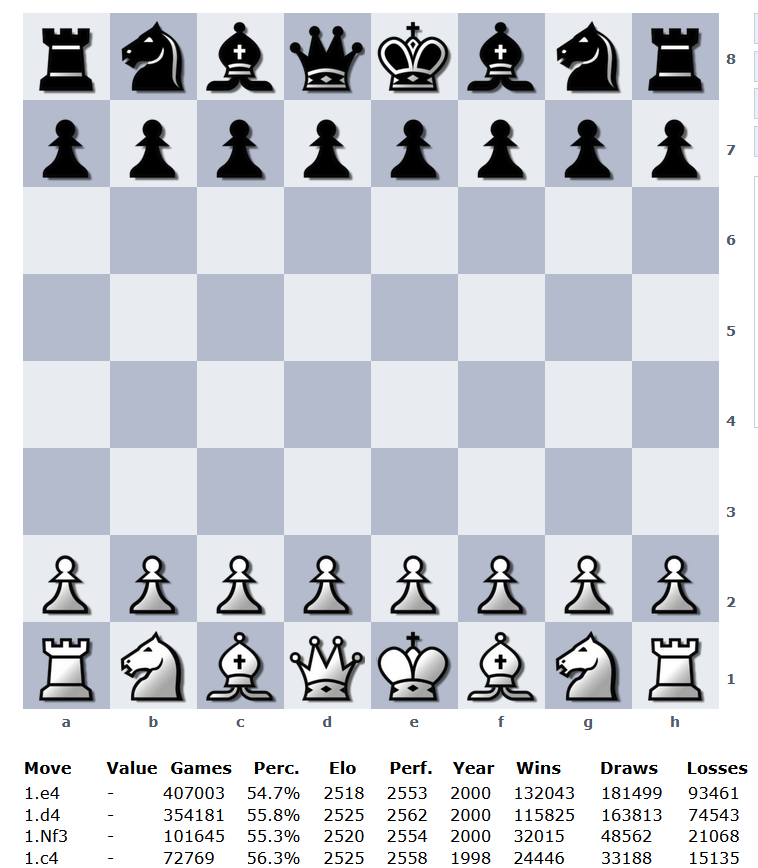

In [37]:
predict_top_moves_from_game()

The model predicts the opening moves for white are:
e4 : 44.12%
d4 : 30.46%
c4 : 12.36%


The model correctly picks the first two top moves in the correct order, but it misses the third top move in favor of the fourth top move.  This is a good result since the model was trained on a much lower sample of games than the database, and there are a lot of moves white can play on the first move of the game.

**Black's reply to King pawn opening**

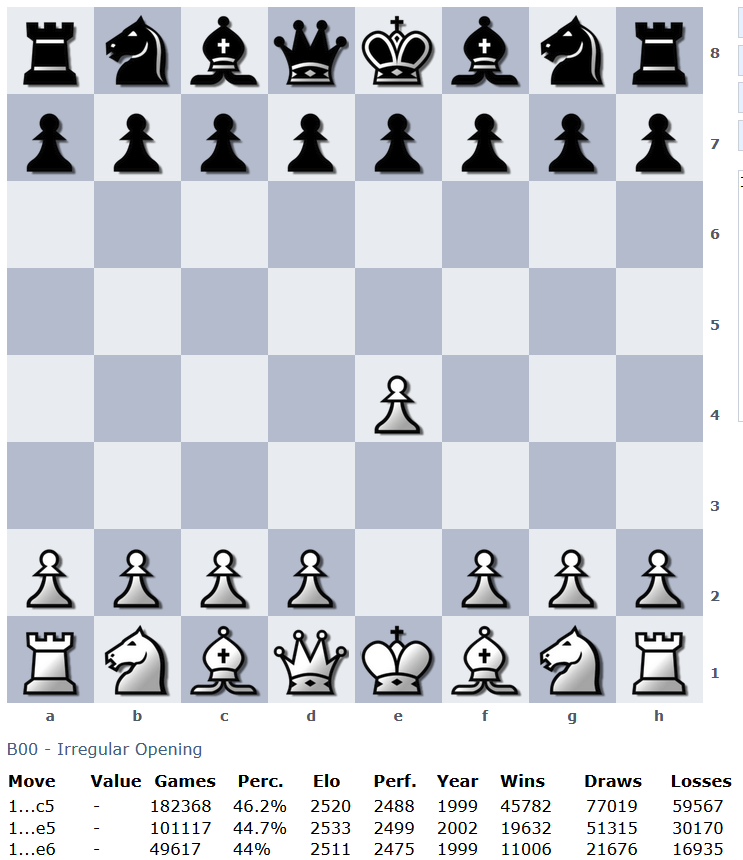

In [38]:
predict_top_moves_from_game('1. e4')

After ('e4',), the model predicts the popular moves are:
c5 : 38.24%
e5 : 37.87%
e6 : 13.17%


The model correctly predicts the popular moves by black in the right order.  

**White's third move after King Pawn Opening**


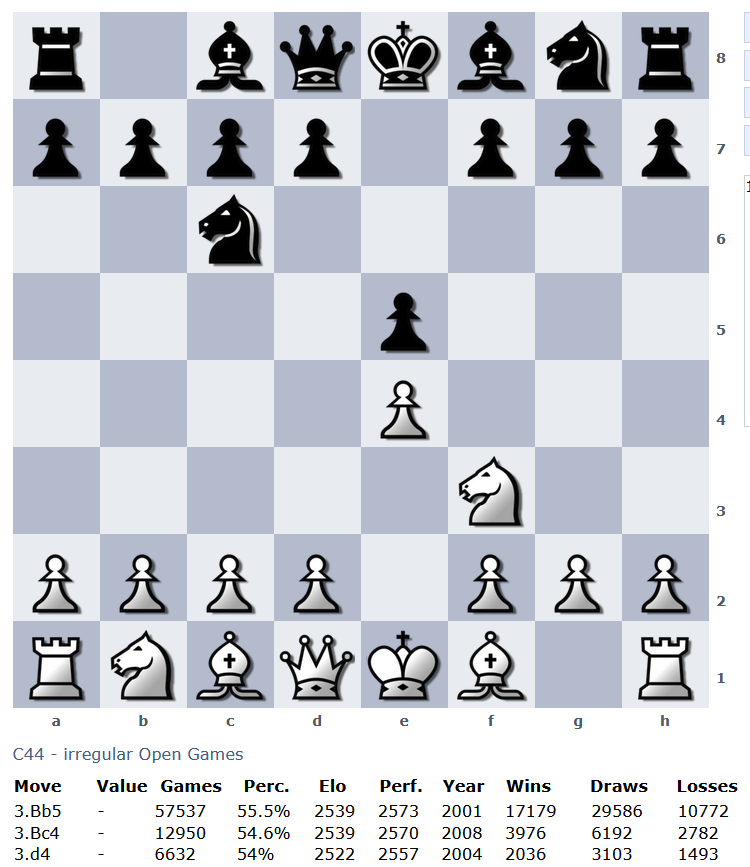

In [39]:
predict_top_moves_from_game('1. e4 e5 2. Nf3 Nc6')

After ('e4', 'e5', 'Nf3', 'Nc6'), the model predicts the popular moves are:
Bb5 : 74.11%
Bc4 : 17.58%
d4 : 5.23%


The model correctly predicts the top moves in the right order of popularity.

**Black's third move in the Scandinavian defense**

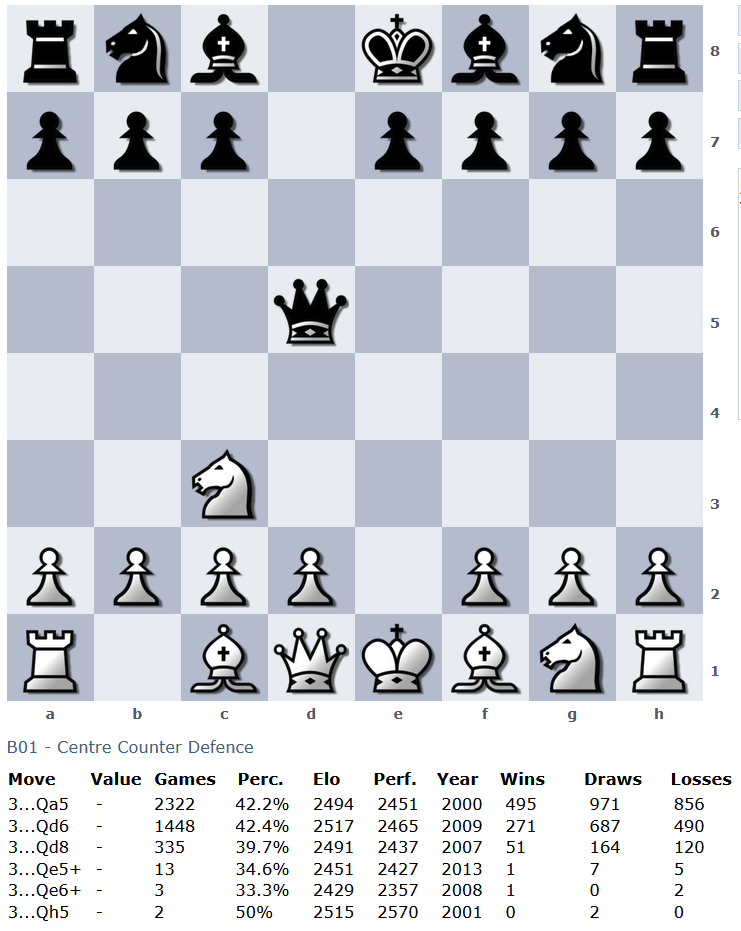

In [40]:
predict_top_moves_from_game('1. e4 d5 2. exd5 Qxd5 3. Nc3')

After ('e4', 'd5', 'exd5', 'Qxd5', 'Nc3'), the model predicts the popular moves are:
Qa5 : 41.67%
Qd6 : 38.54%
Qe6+ : 8.33%


The model correctly predicts the popular move in this position, but misses the second top move in favor of the third.  

**White's fourth move in the Scotch Game**

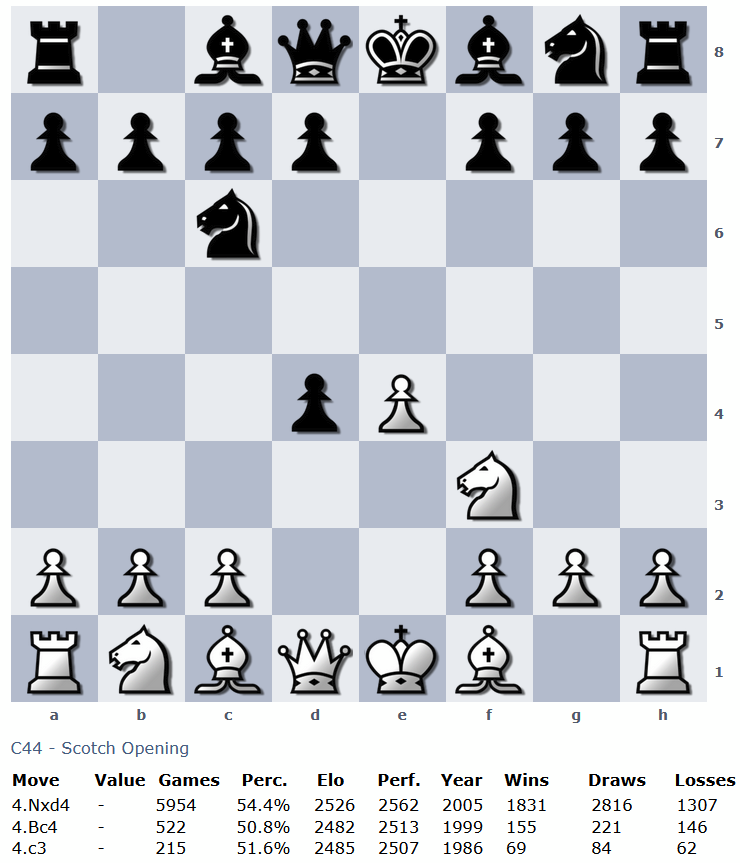

In [41]:
predict_top_moves_from_game('1. e4 e5 2. Nf3 Nc6 3. d4 exd4')

After ('e4', 'e5', 'Nf3', 'Nc6', 'd4', 'exd4'), the model predicts the popular moves are:
Nxd4 : 92.52%
Bc4 : 6.46%
c3 : 1.02%


The model correctly predicts the top moves in the right order of popularity.

**Black's fourth move in the Sicilian defense**

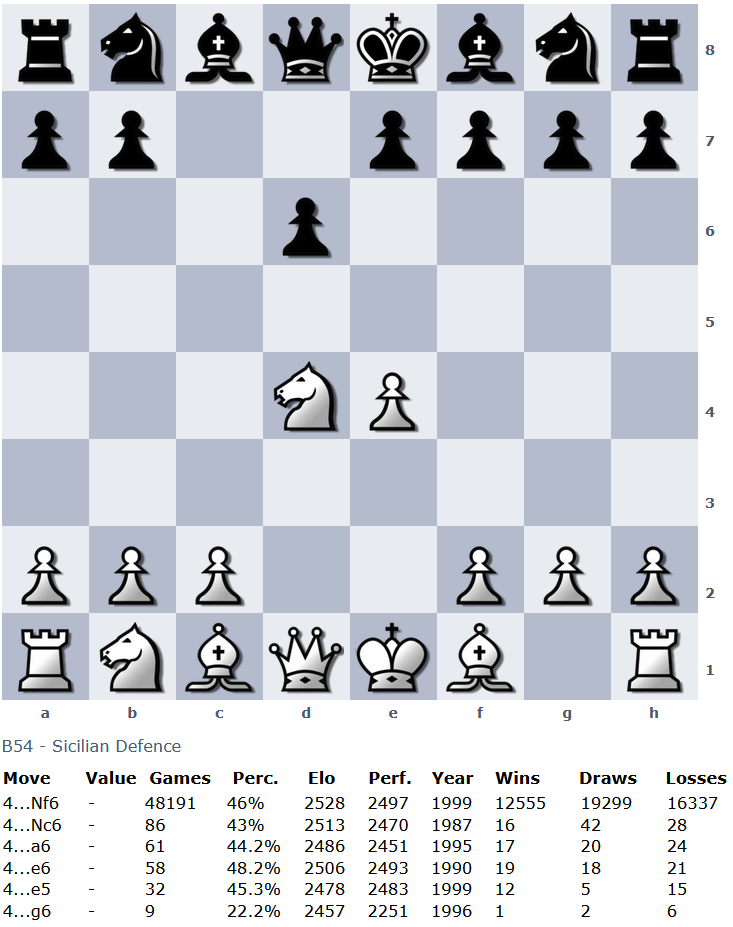

In [42]:
predict_top_moves_from_game('1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4')

After ('e4', 'c5', 'Nf3', 'd6', 'd4', 'cxd4', 'Nxd4'), the model predicts the popular moves are:
Nf6 : 99.23%
g6 : 0.52%
Nc6 : 0.09%


The model correctly predicts the popular move in this position, but misses the second top move in favor of the third.  The move g6 is in the top six moves.  

**White's fifth move in the Nimzo-Indian defense**

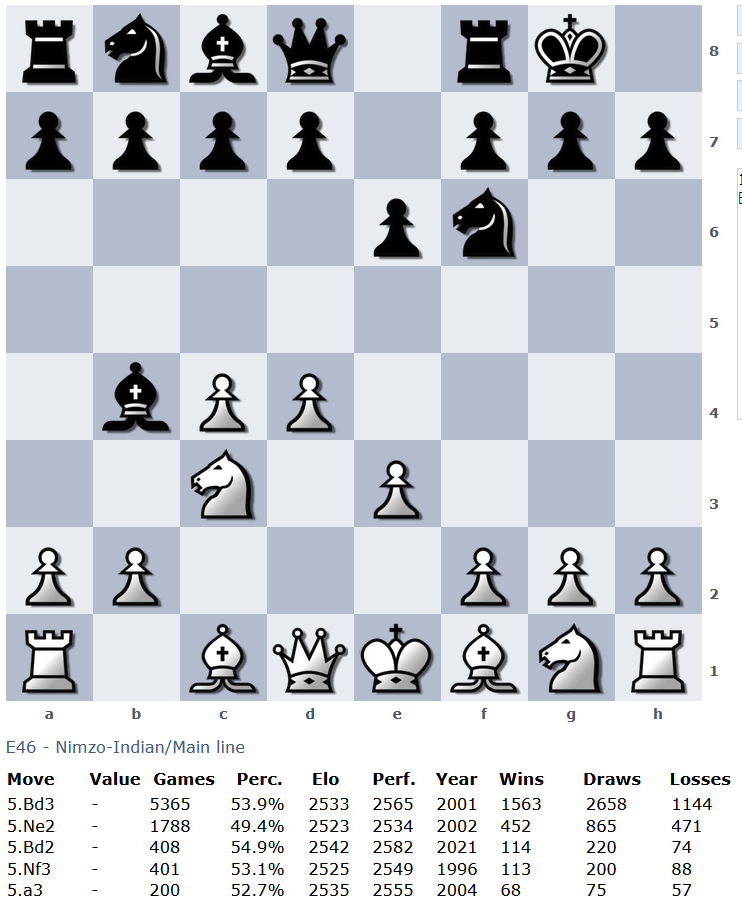

In [43]:
predict_top_moves_from_game('1. d4 Nf6 2. c4 e6 3. Nc3 Bb4 4. e3 O-O')

After ('d4', 'Nf6', 'c4', 'e6', 'Nc3', 'Bb4', 'e3', 'O-O'), the model predicts the popular moves are:
Bd3 : 86.27%
Ne2 : 7.77%
Nf3 : 3.89%


The model correctly predicts the top two moves in the correct order, but misses the third top move in favor of the fourth top move.

**Black's fifth move after the Ruy Lopez opening**

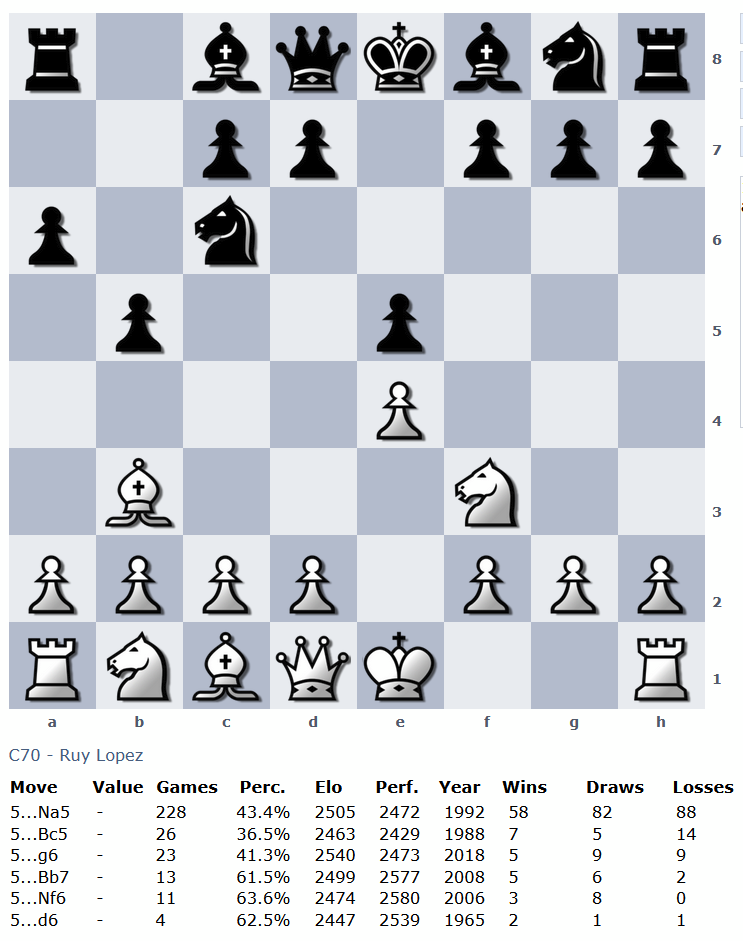

In [44]:
predict_top_moves_from_game('1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 b5 5. Bb3')

After ('e4', 'e5', 'Nf3', 'Nc6', 'Bb5', 'a6', 'Ba4', 'b5', 'Bb3'), the model predicts the popular moves are:
Nf6 : 72.22%
Bb7 : 23.61%
Na5 : 1.39%


Note that even in the database, this position has only been reached around 300 times within the games.  The model does predict moves that are within the top six moves, but it fails to predict the top move accurately.  The Elo for the players within the database for these games is above 2500 whereas the model was trained on games with the players only above 2200.  That could explain the difference, but it could also be the model being trained on very few games of this position, which means the predictions become less accurate as the number of moves increases.  

## **6. Conclusion** <a class="anchor" id="conclude"></a>

The model built on 40,000 chess games with players above 2200 Elo performs well when predicting moves within the fourth move per side.  However, the model starts to fall off after white's fifth move.  

As chess games progress, reaching the same position as another set of players becomes more and more rare, so that decrease in accuracy is expected.  Additionally, chess moves can vary by player since there is no perfect openings for either side as of today.  Without diving into the specific players and their openings within this dataset, there is no way of knowing if it is a representative set of all possible chess openings and styles.  

One other thing to note is that chess players sometimes play different openings depending on the time control (how long each player had to think about moves for the duration of the game).  That factor was not addressed in this analysis, and it is unclear if the database that the model was compared to took that into account as well.

